In [5]:
#Импортируем основные библиотеки
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from scipy.stats import bootstrap, chi2_contingency
import pingouin as pg

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

ARPU = Revenue / Users (чистый доход «поделить» на количество всех пользователей)

In [6]:
AB_df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/SOkIsD5A8xlI7Q', sep = ';')

# EDA

In [7]:
#Количество строк в датафрейме
AB_df.shape[0]

404770

In [8]:
#Типы данных
AB_df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [14]:
#Число уникалтные пользователей
AB_df.user_id.nunique()

404770

In [15]:
#Посмотрим на описательную статистику по группам
AB_df.groupby('testgroup')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,202103.0,25.413720,920.768137,0.0,0.0,0.0,0.0,37433.0
b,202667.0,26.751287,287.324162,0.0,0.0,0.0,0.0,4000.0


In [16]:
#Посмотрим на число уникальных пользователей в двух группах
AB_df\
    .groupby('testgroup')\
    .agg({'user_id' : 'nunique'})\
    .reset_index()

,testgroup,user_id
0,a,202103
1,b,202667


Для дальнейшего удоюства обозначим, что группа **A** - **контрольная группа**, группа **Б** - **тестовая группа**

# ARPU

In [17]:
#Подсчет ARPU
AB_df\
    .groupby('testgroup')\
    .agg({'revenue' : 'mean'})\
    .reset_index()

,testgroup,revenue
0,a,25.413720
1,b,26.751287


По условию ARPU в тестовой группе выше на 5%, исходя из расчетов, полученных выше, это, действительно, так.

In [18]:
#Отберем пользователей в группе А
A_group = AB_df.query("testgroup == 'a'")

In [19]:
#Отберем пользователей в группе Б
B_group = AB_df.query("testgroup == 'b'")

Теперь, когда мы получили датафреймы с ARPU в двух группах, можно приступать к применению статистического теста. В данном случае можно попробовать сравнить средние значения в двух группах с помощью t-критерия Стьюдента для независимых выборок, однако, как мы знаем из теории, у него есть несколько условий:

1. Сравниваемые значения не составляют пару коррелирующих значений(выполнено);

2. Распределение признаков в каждой выборке соответствует нормальному распределению(тест Колмогорова-Смирнова);

3. Дисперсии признака в выборках примерно равны (проверяется с помощью критерия F-Фишера)

Выдвинем следюущие гипотезы: 

​
$H_0$
​
  – в генеральной совокупности в контрольной и тестовой группах ARPU не различаются

$H_1$
​
  – ARPU в генеральной совокупности в тестовой и контрольной группах не равны(в тестовой группе ARPU выше на 5%)
​

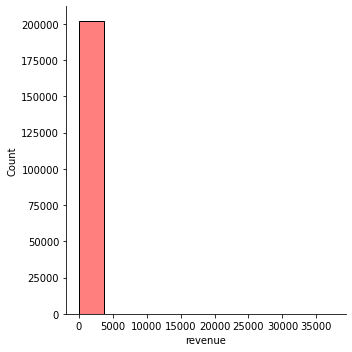

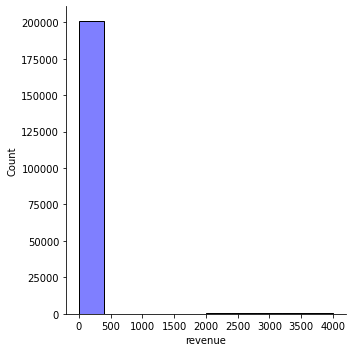

In [22]:
#Построим графики распределения выручки со всех пользователей для двух групп
sns.displot(A_group['revenue'], bins=10, label='Группа A', color = 'red', alpha = 0.5)
sns.displot(B_group['revenue'], bins = 10, label='Группа B', color = 'blue', alpha = 0.5)

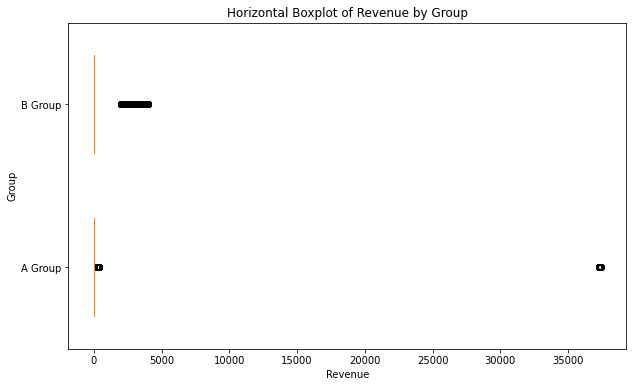

In [29]:
# Построение боксплотов
plt.figure(figsize=(10, 6))

# Боксплот для A_group
plt.boxplot(A_group['revenue'], positions=[1], widths=0.6, vert=False, patch_artist=True, boxprops=dict(facecolor='lightcoral'))
# Боксплот для B_group
plt.boxplot(B_group['revenue'], positions=[2], widths=0.6, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))

plt.yticks([1, 2], ['A Group', 'B Group'])
plt.title('Horizontal Boxplot of Revenue by Group')
plt.ylabel('Group')
plt.xlabel('Revenue')

plt.show()

На графиках видно, что распределение сильно отличается от нормального. К тому же при расчете метрики "ARPU" мы вынуждены оставить в датафрейме пользователей, которые не платят, то есть у которых revenue = 0. Как видно на графике(боксплот), наибольшее количество пользователей не являются покупателями, и поэтому значения, где revenue != 0 воспринимаются, как "выбросы". На боксплоте видно, что медиана лежит у нуля, поэтому привычный формат графика "boxplot" не вырисовывается. Наличие большого количества нулевых значений может негативно повлиять на мощность теста, а также на среднее значение, что исказит результат **t-test**. В статистике рекомендуется применять **Mann-Whitney U test** для анализа данных в такой ситуации, однако эксперты рекомендуют применять его с осторожностью, так как он не проверяет средние значения в двух выборках. Единственный вариант в этом случае - это **bootstap**, однако здесь есть одно большое ограничение в виде размера датафрейма. К примеру, в группе "А" порядка  202103 заказов, и если мы будем ресемплить 10000 раз revenue, то это займет крайне большое количество времени(проверял). В таком случае мы можем снизить количество выборок для скорости вычисления, но это, разумеется, скажется на точности теста. 

В итоге я бы использовал bootstrap с 500-1000 выборками, и просто для наглядности рассчитаю Mann-Whitney U test(не будет использовать при принятии решения). Ну и для того, чтобы точно убедиться в ненормальности распределения переменной, проверим с помощью теста Шапиро-Уилка

In [24]:
#P-value < 0.05 следовательно у нас есть достаточно доказательств, чтобы сказать, что данные выборки не получены из нормального распределения.
stats.kstest(A_group['revenue'], 'norm')

KstestResult(statistic=0.5, pvalue=0.0)

In [25]:
#P-value < 0.05 следовательно у нас есть достаточно доказательств, чтобы сказать, что данные выборки не получены из нормального распределения.
stats.kstest(B_group['revenue'], 'norm')

KstestResult(statistic=0.5, pvalue=0.0)

Теперь можно приступить к применению статистического критерия Mann-Whitney U test, а затем перейти к bootstrap

In [26]:
stat, p  = stats.mannwhitneyu(A_group['revenue'], B_group['revenue'])

In [27]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


p-value > 0.05 следовательно мы можем говорить о том, что статистически значимые различия не обнаружены

Далее сравним доверительные интервалы среднего значения двух бутстрапированных выборок

In [ ]:
#Контрольная группа
data = (A_group['revenue'], )
n_resamples = 1000
bootstrap_ci = bootstrap(data, np.mean, confidence_level=0.95,
                         random_state=1, method='percentile', n_resamples=n_resamples)

print(bootstrap_ci.confidence_interval)

In [21]:
#Тестовая группа
data = (B_group['revenue'], )
n_resamples = 1000
bootstrap_ci = bootstrap(data, np.mean, confidence_level=0.95,
                         random_state=1, method='percentile', n_resamples=n_resamples)

print(bootstrap_ci.confidence_interval)

ConfidenceInterval(low=25.482104511341262, high=28.067122052430836)


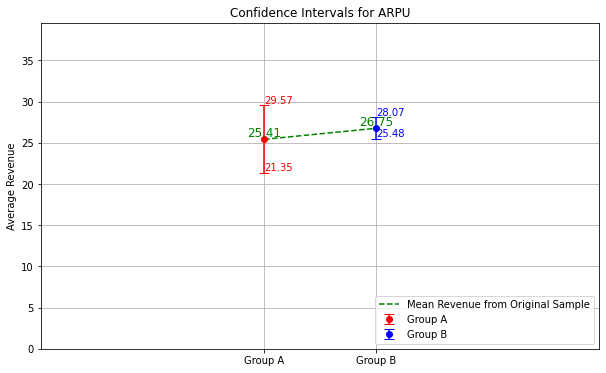

In [28]:
#С реализацией данного графика помогла нейросеть, идею с errorbar нашел на этом сайте: https://www.geeksforgeeks.org/errorbar-graph-in-python-using-matplotlib/

data_A = (A_group['revenue'], )
n_resamples = 1000
bootstrap_ci_A = bootstrap(data_A, np.mean, confidence_level=0.95,
                            random_state=1, method='percentile', n_resamples=n_resamples)

mean_A = np.mean(A_group['revenue'])
lower_A, upper_A = bootstrap_ci_A.confidence_interval

data_B = (B_group['revenue'], )
bootstrap_ci_B = bootstrap(data_B, np.mean, confidence_level=0.95,
                            random_state=1, method='percentile', n_resamples=n_resamples)

mean_B = np.mean(B_group['revenue'])
lower_B, upper_B = bootstrap_ci_B.confidence_interval

plt.figure(figsize=(10, 6))

# График для группы A
plt.errorbar(x=1, y=mean_A, yerr=[[mean_A - lower_A], [upper_A - mean_A]], fmt='o', label='Group A', color='red', capsize=5)

# График для группы B
plt.errorbar(x=1.1, y=mean_B, yerr=[[mean_B - lower_B], [upper_B - mean_B]], fmt='o', label='Group B', color='blue', capsize=5)

plt.text(1, mean_A, f'{mean_A:.2f}', color='green', ha='center', va='bottom', fontsize=12)
plt.text(1.1, mean_B, f'{mean_B:.2f}', color='green', ha='center', va='bottom', fontsize=12)

# Соединение средних значений линией
plt.plot([1, 1.1], [mean_A, mean_B], color='green', linestyle='--', label='Mean Revenue from Original Sample')

# Отображение доверительных интервалов
plt.text(1, lower_A, f'{lower_A:.2f}', color='red', ha='left', va='bottom', fontsize=10)
plt.text(1, upper_A, f'{upper_A:.2f}', color='red', ha='left', va='bottom', fontsize=10)
plt.text(1.1, lower_B, f'{lower_B:.2f}', color='blue', ha='left', va='bottom', fontsize=10)
plt.text(1.1, upper_B, f'{upper_B:.2f}', color='blue', ha='left', va='bottom', fontsize=10)

# Настройки графика
plt.xticks([1, 1.1], ['Group A', 'Group B'])
plt.ylabel('Average Revenue')
plt.title('Confidence Intervals for ARPU')

# Установка границ оси Y
plt.ylim(0, max(upper_A, upper_B) + 10)  # Устанавливаем верхнюю границу немного выше максимума

# Установка границ оси X
plt.xlim(0.8, 1.3)  # Уменьшаем диапазон оси X для приближения

# Перемещение легенды в правый нижний угол
plt.legend(loc='lower right')

plt.grid()

# Показать график
plt.show()

В данном случае мы видим, что доверительные интервалы средних значений в двух группах пересекаются между собой, следовательно мы можем говорить о том, что в генеральной совокупности статистически значимые различия не обнаружены, у нас не достаточно оснований отклонить нулевую гипотезу

# ARPPU

Рассмотрим следующую метрику: **ARPPU**

ARPPU = Revenue / Paying Users (чистый доход «поделить» на количество платящих пользователей)

In [30]:
#Поделим выручку с каждого пользователя на количество пользователей в каждой группе для удобства в дальнейших рассчетах
A_group['ARPPU'] = A_group.revenue.apply(lambda x: x/1928)
B_group['ARPPU'] = B_group.revenue.apply(lambda x: x/1805)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


При проверке гипотезы о различии метрики в двух группах будем руководствоваться той же логикой, что и при расчете ARPU, только ради разнообразия поменяем тест при проверке на нормальность:

1. Сравниваемые значения не составляют пару коррелирующих значений(выполнено);

2. Распределение признаков в каждой выборке соответствует нормальному распределению(тест Шапиро-Уилка);

3. Дисперсии признака в выборках примерно равны (проверяется с помощью критерия F-Фишера)

В конечном итоге будет принято решение о применении t-test для двух независимых выборок или же выборе иного метода для анализа двух переменных

Начнем с проверки на нормальность:

In [32]:
#Также немаловажным при расчете данной метрики избавиться от неплатящих игроков
A_group_2 = A_group.query("revenue != 0")
B_group_2 = B_group.query("revenue != 0")

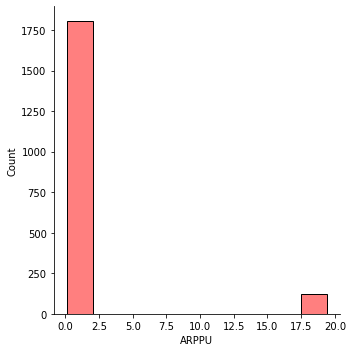

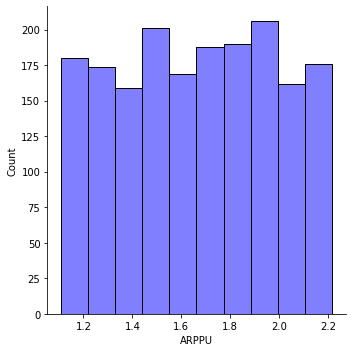

In [23]:
#Построим графики распределения ARPPU в двух группах
sns.displot(A_group_2['ARPPU'], bins=10, label='Группа A', color = 'red', alpha = 0.5)
sns.displot(B_group_2['ARPPU'], bins = 10, label='Группа B', color = 'blue', alpha = 0.5)

Собственно как и в случае с ARPU игроки в первой группе совершают покупки на меньшую сумму(за исключением нескольких крупных покупок), а вот в тестовой наоборот - сумма, как правило, выше, именно поэтому за счет крупных покупок у ряда пользователей в контрольной группе, среднее значение находится приблизительно на одном уровне в выборках. 

Если мы посмотрим на данные из группы "A" чуть ближе,то сможем выделить кластеры на основе выручки, которыую принесли пользователи. Как и было сказано ранее, в контрольной группе есть пользователи, которые совершают небольшие покупки, а есть пользователи, которые делают покупки на большие суммы. В дальнейшем можно было бы ознакомиться с данным вопросом подробнее и попытаться выделить эти кластеры.

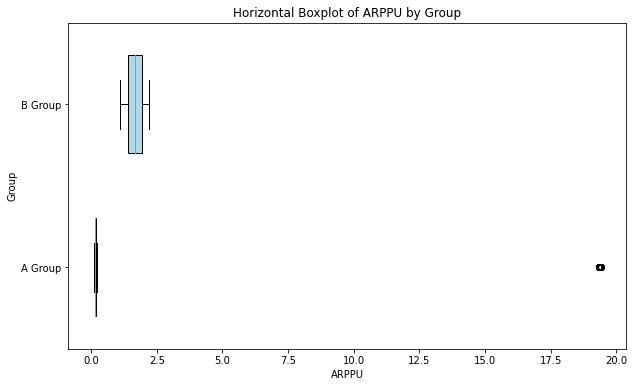

In [33]:
# Построение боксплотов
plt.figure(figsize=(10, 6))

# Боксплот для A_group
plt.boxplot(A_group_2['ARPPU'], positions=[1], widths=0.6, vert=False, patch_artist=True, boxprops=dict(facecolor='lightcoral'))
# Боксплот для B_group
plt.boxplot(B_group_2['ARPPU'], positions=[2], widths=0.6, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))

# Настройка осей и заголовков
plt.yticks([1, 2], ['A Group', 'B Group'])
plt.title('Horizontal Boxplot of ARPPU by Group')
plt.ylabel('Group')
plt.xlabel('ARPPU')

plt.show()

Ситуация схожа с метрикой ARPU: в двух группах распределние переменной сильно отличется от нормального, однако медиана в тестовой группе будет лежать в диапазоне 1,7. Также дополнительно проверим результат с помощью статистических тестов

In [34]:
#контрольная группа
pg.normality(A_group_2['ARPPU'])

,W,pval,normal
ARPPU,0.266792,0.0,False


In [35]:
#тестовая группа
pg.normality(B_group_2['ARPPU'])

,W,pval,normal
ARPPU,0.958312,2.491114e-22,False


В двух группах p-value оказался меньше порогового значения - 0.05, что говорит о том, что переменные распределены ненормально. В таком случае алгоритм будет идентичным прошлой метрике: рассмотрим **U-Манна-Уитни**, пусть его и не рекомендуют использовать в качестве теста, который сравнивает средние значения, так как высота ошибка первого рода кратно растет при его применении(не будет использовать при принятии решений), а затем воспользуемся **bootstrap**, чтобы сделать вывод о различия. Перед тем, как приступать к тестам, посмотрим, как выглядят средние значения метрик в двух выборках(группах)

In [28]:
#Контрольная группа
A_group_2['ARPPU'].sum()

2663.9984439834025

In [29]:
#Тестовая группа
B_group_2['ARPPU'].sum()

3003.6581717451522

Выдвинем следюущие гипотезы: 

​
$H_0$
​
  – в генеральной совокупности ARPPU в двух группах не различаются

$H_1$
​
  – в генеральной совокупности ARPPU в двух группах различаются (альтернативная гипотеза)
​

In [30]:
stat2, p2  = stats.mannwhitneyu(A_group_2['ARPPU'], B_group_2['ARPPU'])

In [31]:
prob = 0.95
alpha = 1.0 - prob
if p2 <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


Выводов по поводу данного теста не будет, приступим к bootstrap. Важно дополнить, что теперь две группы имеют сравнительно небольшой размер, и теперь можно сформировать гораздо больше повторных выборок

In [36]:
#Контрольная группа
data = (A_group_2['ARPPU'], )
n_resamples = 10000
bootstrap_ci = bootstrap(data, np.sum, confidence_level=0.95,
                         random_state=1, method='percentile', n_resamples=n_resamples)

print(bootstrap_ci.confidence_interval)

ConfidenceInterval(low=2278.579253112033, high=3067.9626037344397)


In [37]:
#Тестовая группа 
data = (B_group_2['ARPPU'], )
n_resamples = 10000
bootstrap_ci = bootstrap(data, np.sum, confidence_level=0.95,
                         random_state=1, method='percentile', n_resamples=n_resamples)

print(bootstrap_ci.confidence_interval)

ConfidenceInterval(low=2976.988975069252, high=3030.1494875346266)


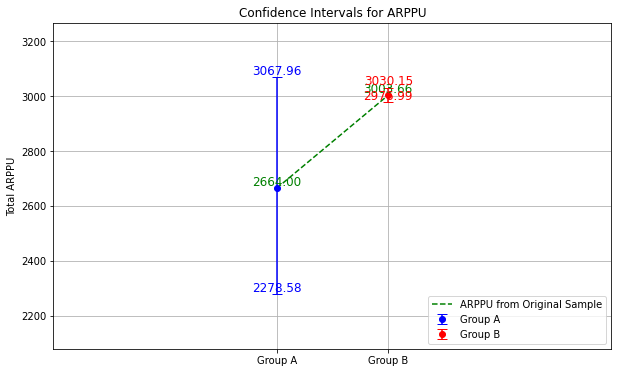

In [38]:
#С реализацией данного графика помогла нейросеть, идею с errorbar нашел на этом сайте: https://www.geeksforgeeks.org/errorbar-graph-in-python-using-matplotlib/
# Контрольная группа
data_A = (A_group_2['ARPPU'], )
n_resamples = 10000
bootstrap_ci_A = bootstrap(data_A, np.sum, confidence_level=0.95,
                            random_state=1, method='percentile', n_resamples=n_resamples)

mean_A = np.sum(A_group_2['ARPPU'])
lower_A, upper_A = bootstrap_ci_A.confidence_interval

# Тестовая группа
data_B = (B_group_2['ARPPU'], )
bootstrap_ci_B = bootstrap(data_B, np.sum, confidence_level=0.95,
                            random_state=1, method='percentile', n_resamples=n_resamples)

mean_B = np.sum(B_group_2['ARPPU'])
lower_B, upper_B = bootstrap_ci_B.confidence_interval

plt.figure(figsize=(10, 6))

# График для группы A
plt.errorbar(x=1, y=mean_A, yerr=[[mean_A - lower_A], [upper_A - mean_A]], fmt='o', label='Group A', color='blue', capsize=5)

# График для группы B
plt.errorbar(x=1.1, y=mean_B, yerr=[[mean_B - lower_B], [upper_B - mean_B]], fmt='o', label='Group B', color='red', capsize=5)

plt.text(1, mean_A, f'{mean_A:.2f}', color='green', ha='center', va='bottom', fontsize=12)
plt.text(1.1, mean_B, f'{mean_B:.2f}', color='green', ha='center', va='bottom', fontsize=12)

# Соединение средних значений линией
plt.plot([1, 1.1], [mean_A, mean_B], color='green', linestyle='--', label='ARPPU from Original Sample')

# Отображение доверительных интервалов
plt.text(1, lower_A, f'{lower_A:.2f}', color='blue', ha='center', va='bottom', fontsize=12)
plt.text(1, upper_A, f'{upper_A:.2f}', color='blue', ha='center', va='bottom', fontsize=12)
plt.text(1.1, lower_B, f'{lower_B:.2f}', color='red', ha='center', va='bottom', fontsize=12)
plt.text(1.1, upper_B, f'{upper_B:.2f}', color='red', ha='center', va='bottom', fontsize=12)

# Настройки графика
plt.xticks([1, 1.1], ['Group A', 'Group B'])
plt.ylabel('Total ARPPU')
plt.title('Confidence Intervals for ARPPU')

# Установка границ оси Y с небольшим отступом
y_min = min(lower_A, lower_B) - 200  # Увеличиваем нижнюю границу
y_max = max(mean_A, mean_B, upper_A, upper_B) + 200  # Увеличиваем верхнюю границу
plt.ylim(y_min, y_max)

# Установка границ оси X
plt.xlim(0.8, 1.3)

# Перемещение легенды в правый нижний угол
plt.legend(loc='lower right')

plt.grid()

# Показать график
plt.show()

Мы видим, что доверительные интервалы пересекаются между собой, следовательно у нас не достаточно оснований для того, чтобы отклонить нулевую гипотезу. Мы говорим о том, что в генеральной соовкупности никакого различия в ARPPU между двумя группами нет.

**Важное дополнение**: можно было рассчитывать ARPPU иначе: сложить выручку со всех пользователей и поделить на количество платящихпользователей в группе, а затем засемплировать данное значение в функции рассчета бутстрапа, но, как мне кажется, вариант, предложенный мной, имеет право на существование, ведь если сложить все значения в столбце ARPPU, то мы как раз получим то самое значение ARPPU при делении выручки на платящих пользователей. При визуализации я использовал столбец ARPPU, а не revenue осознанно, так как сам стобец ARPPU делится на константу, что в целом не должно сказываться на форме самого распределения(я проверял)

# Количество покупок

Далее рассмотрим метрику "количество покупок". В условии дано, что в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. Для того, чтобы сравнить две группы между собой и определить, дейтсвительно ли в генеральной совокупности сохраняется такое соотношение, воспользуется анализом таблиц сопряженности, а именно критерием хи-квадрат Пирсона. Выдвинем следюущие гипотезы:


- $H_0$: Нет значимой разницы в количестве покупок между тестовой и контольной группой


- $H_1$: Есть значимая разница в количестве покупок между тестовой и контрольной группами


План действий такой: создадим пустой лист, который заполним значениями "buying" и "not buying", где "buying" = revenue>0, а "not buying" = 0, соотвественно. Данный способ облегчит создание таблицы сопряженности, которая нужна для анализа

In [44]:
#Создадим пустой лист
lst = []

In [45]:
#Цикл для отбора нужных строк
for i in AB_df['revenue']:
    if i > 0:
        lst.append('buying')
    else:
        lst.append('not buying')       

In [46]:
AB_df['status'] = lst

In [47]:
#Создадим таблицу сопряженности для наглядности 
pd.crosstab(AB_df['status'], AB_df['testgroup'])

testgroup,a,b
status,,
buying,1928,1805
not buying,200175,200862


In [48]:
#Применим хи-квадрат Пирсона к получившийся сводной таблице
stat, p, dof, expected = chi2_contingency(pd.crosstab(AB_df.status, AB_df.testgroup))

In [49]:
stat, p, dof

(4.374729521260405, 0.03647561892312613, 1)

In [50]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


Таким образом, мы получили результат p-value < 0.05, а также полученное значение Хи-квадрат(4.4) > критического(3.84), следовательно мы можем отклонить нулевую гипотезу о равенстве количества покупок в тестовой и контрольной группах. Оказалось, что в контрольной группе игроки имеют большее количество покупок, нежели в тестовой. 

В итоге на данном этапе мы имеем довольно сомнительный результат: метрки ARPU и ARPPU не прокрасились, в то время как метрика "количество покупок" показала, что в контрльной группе платящих пользователей больше, следовательно набор акционных предложений для контрольной группы оказался успешнее. 

К сожалению, данный датафрейм не располагает дополнительными данными, которые можно было бы использовать для различных метрик, к примеру: Retention Rate, LTV, AOV и так далее. Дополнительно можно было бы рассмотреть момент, на который я указывал выше - анализ кластеров в контрольной группе. Воспользуемся подходом, который обычно используется при RFM-сегментации: определим кластеры на основе квантилей.

# Кластеры

In [54]:
quantiles=A_group.query("revenue !=0")['revenue'].quantile(q = [0.25, 0.5, 0.75])
quantiles

0.25    257.0
0.50    311.0
0.75    361.0
Name: revenue, dtype: float64

В итоге мы получили значения, которые отражают квантили распредления выручки в группе "А". Однако квантили не полностью отражают реальное положение дел: как мы помним из графиков, у нас были значения, которые сильно выбиваются из общей массы - выбросы, где чеки пользователей первышали 30000. 

In [55]:
#Снова создадим даатфрейм с платящими пользователями
rev_clusters = A_group.query("revenue !=0")

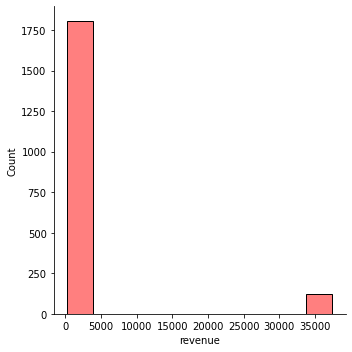

In [56]:
#Построим график
sns.displot(rev_clusters['revenue'], bins = 10, label='Группа B', color = 'r', alpha = 0.5)

Собственно, мы видим, что отчетливо выделяются два кластера на графике, однако значения, которые меньше 30000 тоже можно поделить на небольшие кластеры. Если мы посмотрем на список этих значений подробнее, то там можно встретить значения от 200 до 400, и, учитывая квантили, которые были использованы выше, можно выделить следующие кластеры по возрастанию выручки: 

1. кластер:  200-257

2. кластер: 257-311

3. кластер: 311-361

4. кластер 361-400

5. кластер: больше 1000

In [57]:
def cluster_num(x):
    if x >= 200 and x <= 257:
        return 1
    elif x > 257 and x <= 311:
        return 2
    elif x > 311 and x <= 361:
        return 3
    elif x > 361 and x <= 400:
        return 4
    else:
        return 5

In [58]:
rev_clusters['cluster'] = rev_clusters['revenue'].apply(lambda x: cluster_num(x))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [60]:
#Итоговый вариант таблицы
rev_clusters.head()

,user_id,revenue,testgroup,ARPPU,cluster
72,73,351,a,0.182054,3
341,342,290,a,0.150415,2
385,386,250,a,0.129668,1
416,417,37324,a,19.358921,5
712,713,255,a,0.132261,1


В итоге мы получили кластеры, которые деляют платящих игроков по выручке, которую они принесли продукту. Для выполнения задания данное действие не требовалось, однако в теории заказчику может потребоваться такая информация о пользователях в будущем.

# Выводы

К сожалению, набор акционных предложений для тестовой группы не может быть использован в продакшене. Гипотезы о различиях метрик ARPU и ARPPU в контрольной и тестовых группах не подствердились, однако анализ метрики "Количество покупок" подтвердил статистически значимые различия в генеральной совокупности между группами, однако не в пользу тестовой: в контрольной группе больше платящих пользователей. 

Дополнительно я разделил пользователей в контрольной группе на кластеры, что в теории могло бы быть полезно заказчику. К сожалению, как и было сказано выше, данный датафрейм располагает сравнительно небольшим куском данных для анализа. Можно было бы рассчитать множество других полезных метрик для бизнеса: RR, MAU, DAU, AOV. Едиснтвенная метрика, которую я упустил в данном задании - это Convertion Rate. Я бы мог сравнить конвермию в покупку в двух группах, но, как мне кажется, нехватка данной метрики восполняется метрикой "Количество покупок". 